In [135]:
from itertools import product
import numpy as np
import random 
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import nashpy as nash

def sum_pairs(S):
    pairs = []
    for i in range(S+1):
        pair = np.array([i, S-i])
        pairs.append(pair)
    return pairs


def get_strategies(N, S):
    pure_strats = []
    #First battlefield value is i
    for i in range(S+1):
        #Other battlefields 
        #values 
        for j in sum_pairs(S -i):
            pure_strats.append(tuple(np.insert(j, 0, i)))
    return((pure_strats))

ids = np.arange(0, 21)
strats = get_strategies(3, 5)
mu = 100
play = 0

score = []
for i in range(21):
    for j in range(21):
            score.append(np.sum(np.array(strats[i]) > np.array(strats[j])))

score = np.array(score)
payoff = score.reshape(21, 21)
payoff -= np.transpose(payoff) #make zero sum version
A = payoff
B = -(A)


def select_strat(strats, regret_vector):
    # if all zeros in vector - make uniform probability distribution
    if np.count_nonzero(regret_vector) == 0:
        prob_vec = np.ones(21)

    # turn regret vector into probability vector if not all zeros.
    else:
        prob_vec = regret_vector
    
    play = random.choices(ids, weights = prob_vec)
    return strats[play[0]], play


def aggregate_payoff(p1_move, p2_move):

    p1_wins = 0
    p2_wins = 0
    for p1, p2 in zip(p1_move, p2_move):
        if p1 > p2:
            p1_wins += 1
        elif p2 > p1:
            p2_wins += 1

    if p1_wins > p2_wins:
        return +1
    elif p2_wins > p1_wins:
        return -1
    else:
        return 0
    
    
    
def update_regret_vector(regret_vector, strats, p1_strat, p2_strat):

    game_payoff = aggregate_payoff(p1_strat, p2_strat)

    #Iteratively updating the regret vector
    updated_regret_vector = [
        (val + (aggregate_payoff(strats[idx], p2_strat) -
               game_payoff)) for idx, val in enumerate(regret_vector)
    ]

    # Make non-negative
    pos_regret_vector = [regret if regret > 0 else 0 for regret in updated_regret_vector]

    return pos_regret_vector

In [136]:
n_iter = 100000
N = 3
S = 5

p1_moves = get_strategies(N, S)
p2_moves = get_strategies(N, S)

p1_regret = np.zeros(21)
p2_regret = np.zeros(21)

p1_average_strategy = np.zeros(21)
p2_average_strategy = np.zeros(21)

p1_average_payoff = []

regret_list = []
p1_list = [0]
p2_list = [0]
joint_actions = []
for t in range(1, n_iter+1):
    #Picking new strategy
    p1_move, p1_index = select_strat(p1_moves, p1_regret)
    p2_move, p2_index = select_strat(p2_moves, p2_regret)
    
    #Counter for strategies used
    p1_average_strategy[p1_index] += 1
    p2_average_strategy[p2_index] += 1

    #Average payoff over time
    p1_freq = p1_average_strategy / t
    p2_freq = p2_average_strategy / t
    p1_average_payoff.append(np.dot(p1_freq, np.matmul(A,p2_freq)))

    #Store played strategies
    p1_list.append(p1_index[0])
    p2_list.append(p2_index[0])

    #How quick does the regret go to 0?
    sum_regret = 0
    p1_pos_regret = [val if val > 0 else 0 for val in p1_regret]
    p2_pos_regret = [val if val > 0 else 0 for val in p2_regret]
    regret_list.append((np.array(p1_pos_regret)))

    #Update regret
    p1_regret = update_regret_vector(p1_regret, p1_moves,
                                            p1_move, p2_move)
    p2_regret = update_regret_vector(p2_regret, p2_moves,
                                            p2_move, p1_move)

    
    




In [137]:
joint_dist = np.zeros((21,21))
i = 0
joint_actions = list(zip(p1_list, p2_list))
for x in list(Counter(joint_actions)):
    joint_dist[x[0]][x[1]] = list(Counter(joint_actions).values())[i]
    i += 1


/var/folders/zh/7zp_8xb91cj2g3jy1m3w7kp40000gn/T/ipykernel_57126/2814792743.py:6: RuntimeWarning: overflow encountered in exp
  ax.plot(np.arange(k), np.exp(np.arange(k)))
/opt/homebrew/lib/python3.9/site-packages/matplotlib/ticker.py:2073: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


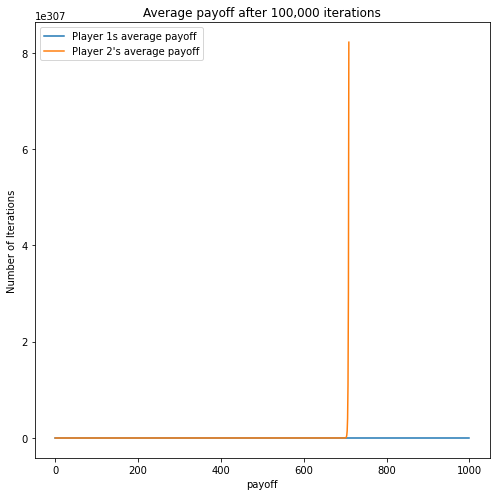

<Figure size 144x144 with 0 Axes>

-0.0006987390000000006


In [145]:
#plot of average payoff over time 
k = 1000
fig, ax = plt.subplots()
fig = plt.figure(figsize=(2, 2))
ax.plot(np.arange(k), np.log(p1_average_payoff + np.ones(len(p1_average_payoff)))[0:k])
ax.plot(np.arange(k), np.exp(np.arange(k)))
ax.legend(["Player 1s average payoff", "Player 2's average payoff"])
ax.set_xlabel("payoff")
ax.set_ylabel("Number of Iterations")
ax.set_title("Average payoff after 100,000 iterations")
plt.savefig("payoff100000")
plt.show()
print(p1_average_payoff[-1])

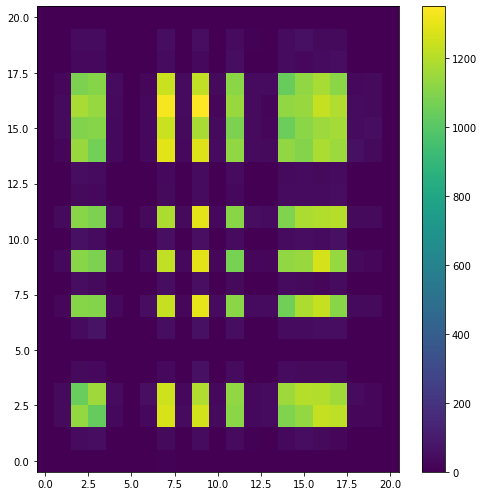

In [139]:
x = np.arange(0, 21)
y = np.arange(0, 21)
lX,lY = np.meshgrid(x,y)


plt.pcolormesh(lX,lY,joint_dist)
plt.colorbar()
plt.savefig("Colourmap.png")
plt.show()



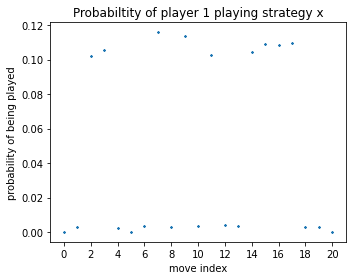

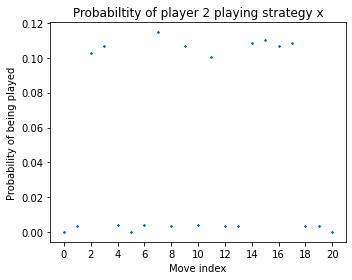

In [132]:
fig = plt.figure(figsize=(5, 4))
ax1 = fig.add_subplot()
x = np.arange(len(p1_average_strategy))
ax1.scatter(x, p1_average_strategy / n_iter, s=3, marker='x')
plt.xticks(np.arange(x[0], x[-1] + 1, step=int(len(p1_moves)/10)))
ax2 = fig.add_subplot(122)
font_size = 8
bbox = [0, 0, 1, 1]
ax2.axis('off')
ax1.set_title("Probabiltity of player 1 playing strategy x")
ax1.set_ylabel('probability of being played')
ax1.set_xlabel('move index')
plt.savefig("strat prob1")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax1 = fig.add_subplot()
x = np.arange(len(p2_average_strategy))
ax1.scatter(x, p2_average_strategy / n_iter, s=3, marker='x')
plt.xticks(np.arange(x[0], x[-1] + 1, step=int(len(p2_moves)/10)))
ax2 = fig.add_subplot(122)
font_size = 8
bbox = [0, 0, 1, 1]
ax2.axis('off')
ax1.set_title("Probabiltity of player 2 playing strategy x")
ax1.set_ylabel('Probability of being played')
ax1.set_xlabel('Move index')
plt.savefig("strat prob2")
plt.show()


Counter({7: 11575, 9: 11389, 17: 10971, 15: 10886, 16: 10868, 3: 10538, 14: 10450, 11: 10238, 2: 10199, 12: 393, 13: 341, 10: 337, 6: 322, 19: 309, 1: 306, 18: 291, 8: 288, 4: 257, 20: 15, 0: 14, 5: 14})


/var/folders/zh/7zp_8xb91cj2g3jy1m3w7kp40000gn/T/ipykernel_57126/3305896723.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.transpose(np.array((ids, strats, list(sorted_dict.values()))))


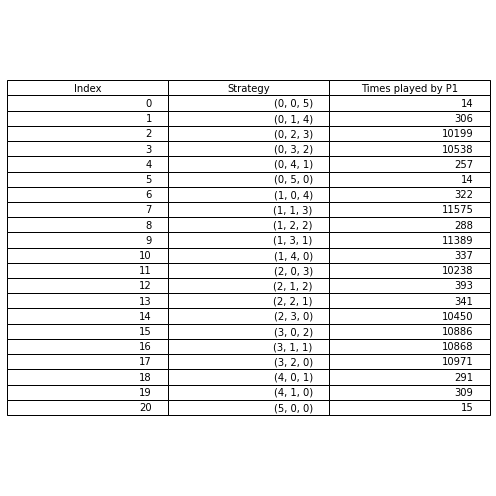

In [133]:
myKeys = list((Counter(p1_list)).keys())
myKeys.sort()
sorted_dict = {i: Counter(p1_list)[i] for i in myKeys}
print(Counter(p1_list))

plt.rcParams["figure.figsize"] = [7,7]
plt.rcParams["figure.autolayout"] = True
fig, axs = plt.subplots(1, 1)
data = np.transpose(np.array((ids, strats, list(sorted_dict.values()))))
columns = ("Index", "Strategy", "Times played by P1")
axs.axis('tight')
axs.axis('off')
the_table = axs.table(cellText=data, colLabels=columns, loc='center')
plt.savefig("games")
plt.show()

[(1, 2, 2), (1, 2, 2), (1, 2, 2), (1, 2, 2), (1, 2, 2), (1, 2, 2), (1, 2, 2), (1, 2, 2), (1, 2, 2)]
[(0, 2, 3), (0, 3, 2), (1, 1, 3), (1, 3, 1), (2, 0, 3), (2, 3, 0), (3, 0, 2), (3, 1, 1), (3, 2, 0)]
[0, 0, 0, 0, -1, -1, 0, 1, 0]


/var/folders/zh/7zp_8xb91cj2g3jy1m3w7kp40000gn/T/ipykernel_57126/4029109530.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.transpose(np.array((a, b, pay_me)))


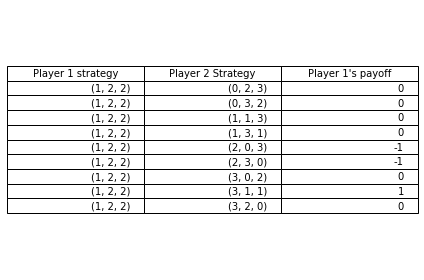

In [8]:

a = []
b_ind = [2, 3, 7, 9, 11, 14, 15, 16, 17]
b = []
pay_me = []
for i in range(9):
    a.append(strats[8])
    b.append(strats[b_ind[i]])
    pay_me.append(payoff[8][b_ind[i]])
print(a)
print(b)
print(pay_me)


plt.rcParams["figure.figsize"] = [7,7]
plt.rcParams["figure.autolayout"] = True
fig, axs = plt.subplots(1, 1)
data = np.transpose(np.array((a, b, pay_me)))
columns = ("Player 1 strategy", "Player 2 Strategy", "Player 1's payoff")
axs.axis('tight')
axs.axis('off')
the_table = axs.table(cellText=data, colLabels=columns, loc='center')
plt.savefig("(2, 2, 1)")
plt.show()

In [36]:

#What if we pit good against good ?
good = np.array([1 if val>0 else 0 for val in pos_avg_pay])
good_vec = np.array(good)
good_vec = good_vec /sum(good_vec)
good_avg_pay = np.zeros(21)
for i in range(21):
    x = np.zeros(21)
    x[i] = 1
    good_avg_pay[i] = np.dot(x, np.matmul(A,good_vec))
print(good)
print(good_avg_pay)


[0 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0]
[-0.66666667 -0.25        0.08333333  0.08333333 -0.25       -0.66666667
 -0.25       -0.08333333 -0.08333333 -0.08333333 -0.25        0.08333333
 -0.08333333 -0.08333333  0.08333333  0.08333333 -0.08333333  0.08333333
 -0.25       -0.25       -0.66666667]


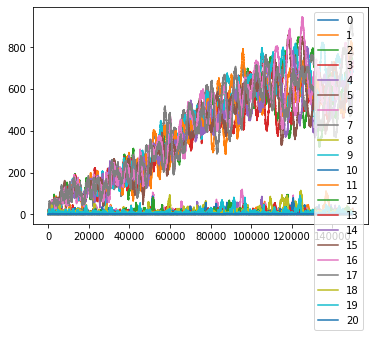

In [8]:
fig, ax = plt.subplots()
ax.plot([i for i in range(n_iter)], regret_list)
ax.legend([i for i in range(21)])
plt.show()


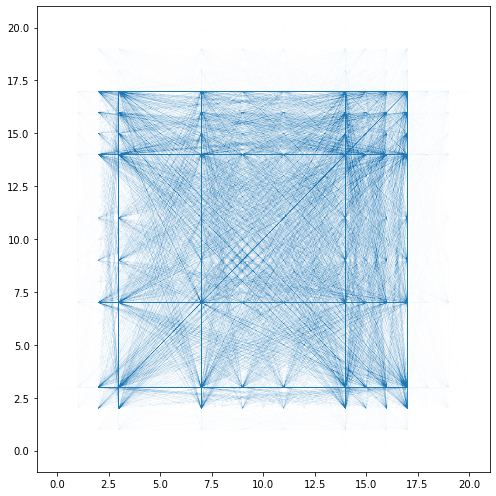

In [134]:
plt.plot(p1_list, p2_list, linewidth = 0.002)
#plt.savefig("replicator3.png")
plt.show()

In [19]:
def rowsums(i,i_):
    total1 = 0
    total2 = 0
    for k in range(21):
        total1 += payoff[i][k] * joint_dist[i][k]
        total2 += payoff[i_][k] * joint_dist[i][k]

    return total1, total2

def isCE(mat):
    sums = []
    indexes1 = []
    epsilon = 0

    for i in range(21):
        for i_ in range(21):
            if rowsums(i,i_)[1] > rowsums(i,i_)[0]:
                sums.append(rowsums(i,i_))
                epsilon = rowsums(i,i_)[1] - rowsums(i,i_)[0]
                indexes1.append(epsilon)
                
    return sums, indexes1




In [113]:
n_iter2 = 100000
N = 3
S = 5

p1_regret = np.zeros(21)
p2_regret = np.zeros(21)

p1_average_strategy = np.zeros(21)
p2_average_strategy = np.zeros(21)

p1_average_payoff = []

regret_list = []
p1_list = [0]
p2_list = [0]

p2_freq = np.zeros(21)

for t in range(1, n_iter2+1):
    #Picking new strategy
    p1_move, p1_index = select_strat(strats, p1_regret)
    p2_move, p2_index = select_strat(strats, np.ones(21))

    
    #Counter for strategies used
    p1_average_strategy[p1_index] += 1
    p2_average_strategy[p2_index] += 1
    p2_freq = p2_average_strategy /t

    #Average payoff over time
    p1_freq = p1_average_strategy / t
    p1_average_payoff.append(np.dot(p1_freq, np.matmul(A,p2_freq)))

    #Store played strategies
    p1_list.append(p1_index[0])
    p2_list.append(p2_index[0])

    #Update regret
    p1_regret = update_regret_vector(p1_regret, p1_moves,
                                            p1_move, p2_move, t)
    p2_regret = update_regret_vector(p2_regret, p2_moves,
                                            p2_move, p1_move, t)

    
    




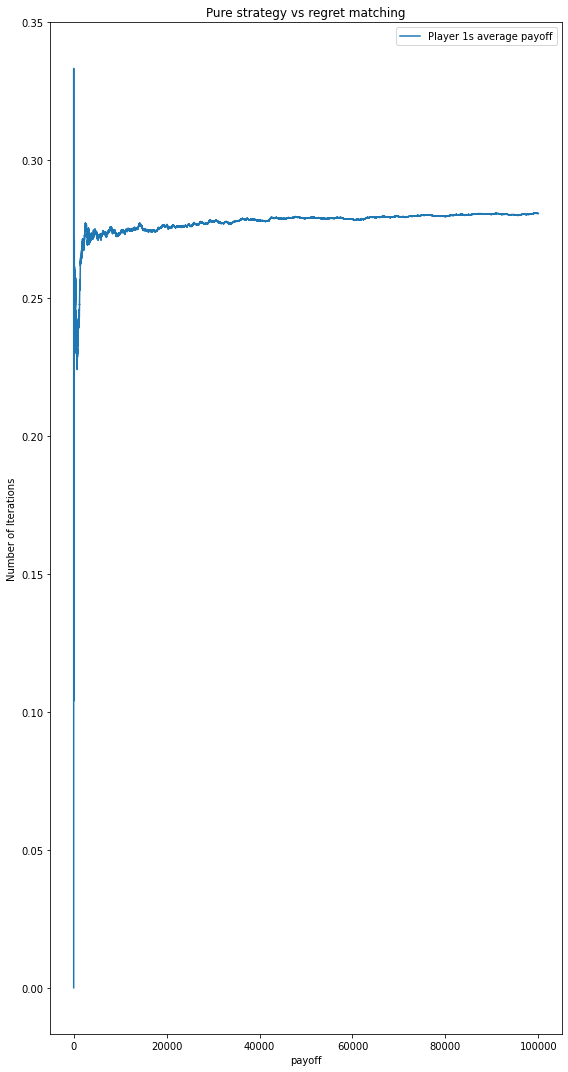

In [120]:
fig, ax = plt.subplots()
ax.plot(np.arange(n_iter2), p1_average_payoff)
ax.legend(["Player 1s average payoff", "Player 2's average payoff"])
ax.set_xlabel("payoff")
ax.set_ylabel("Number of Iterations")
ax.set_title("Pure strategy vs regret matching")
#plt.savefig("regret vs random")
plt.show()


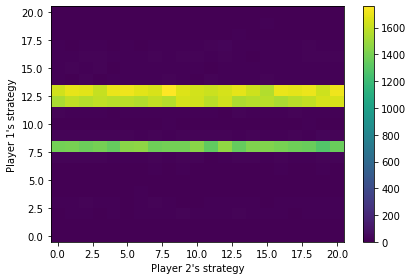

In [81]:
joint_dist = np.zeros((21,21))
i = 0
joint_actions = list(zip(p1_list, p2_list))
for x in list(Counter(joint_actions)):
    joint_dist[x[0]][x[1]] = list(Counter(joint_actions).values())[i]
    i += 1

x = np.arange(0, 21)
y = np.arange(0, 21)
lX,lY = np.meshgrid(x,y)




fig, ax = plt.subplots()
sp = ax.pcolormesh(lX,lY,joint_dist)
fig.colorbar(sp)
ax.set_xlabel("Player 2's strategy")
ax.set_ylabel("Player 1's strategy")
plt.savefig("randomcolour")
plt.show()

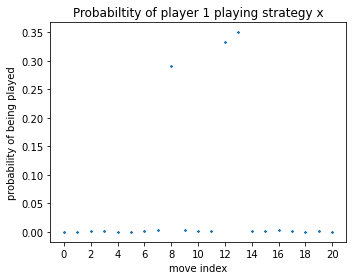

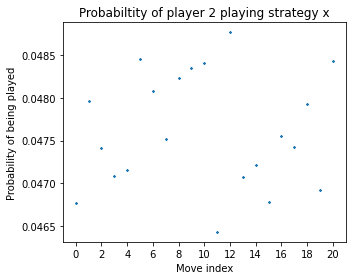

In [83]:
fig = plt.figure(figsize=(5, 4))
ax1 = fig.add_subplot()
x = np.arange(len(p1_average_strategy))
ax1.scatter(x, p1_average_strategy / n_iter2, s=3, marker='x')
plt.xticks(np.arange(x[0], x[-1] + 1, step=int(len(p1_moves)/10)))
ax2 = fig.add_subplot(122)
font_size = 8
bbox = [0, 0, 1, 1]
ax2.axis('off')
ax1.set_title("Probabiltity of player 1 playing strategy x")
ax1.set_ylabel('probability of being played')
ax1.set_xlabel('move index')
plt.savefig("vsuniform")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax1 = fig.add_subplot()
x = np.arange(len(p2_average_strategy))
ax1.scatter(x, p2_average_strategy / n_iter2, s=3, marker='x')
plt.xticks(np.arange(x[0], x[-1] + 1, step=int(len(p2_moves)/10)))
ax2 = fig.add_subplot(122)
font_size = 8
bbox = [0, 0, 1, 1]
ax2.axis('off')
ax1.set_title("Probabiltity of player 2 playing strategy x")
ax1.set_ylabel('Probability of being played')
ax1.set_xlabel('Move index')
plt.savefig("uniform")
plt.show()

[-0.47619047619047616, -0.09523809523809523, 0.09523809523809523, 0.09523809523809523, -0.09523809523809523, -0.47619047619047616, -0.09523809523809523, 0.19047619047619047, 0.2857142857142857, 0.19047619047619047, -0.09523809523809523, 0.09523809523809523, 0.2857142857142857, 0.2857142857142857, 0.09523809523809523, 0.09523809523809523, 0.19047619047619047, 0.09523809523809523, -0.09523809523809523, -0.09523809523809523, -0.47619047619047616]


/var/folders/zh/7zp_8xb91cj2g3jy1m3w7kp40000gn/T/ipykernel_57126/984988214.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.transpose(np.array((strats, payoff_array)))


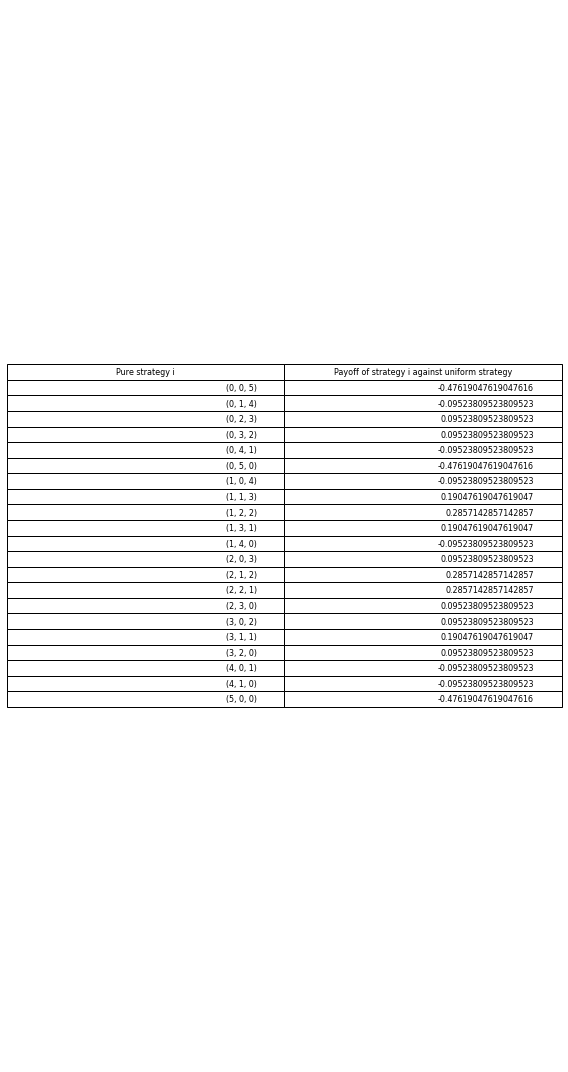

In [118]:
uniform_strat = np.ones(21)/21
payoff_array = []
for i in range(21):
    strat = np.zeros(21)
    strat[i] = 1
    payoff_array.append(np.matmul(strat, np.matmul(payoff, uniform_strat)))

print(payoff_array)
plt.rcParams["figure.figsize"] = [8,15]
plt.rcParams["figure.autolayout"] = True
fig, axs = plt.subplots(1, 1)
data = np.transpose(np.array((strats, payoff_array)))
columns = ("Pure strategy i", "Payoff of strategy i against uniform strategy")
axs.axis('tight')
axs.axis('off')
the_table = axs.table(cellText=data, colLabels=columns, loc='center', fontsize = 50)
plt.savefig("uniformpayoff")
plt.show()

In [117]:
print(payoff)

[[ 0  0  0  0  0  0  0 -1 -1 -1 -1  0 -1 -1 -1  0 -1 -1  0 -1  0]
 [ 0  0  0  0  0  0  0  0 -1 -1 -1  1  0 -1 -1  1  0 -1  1  0  1]
 [ 0  0  0  0  0  0 -1  0  0 -1 -1  0  1  0 -1  1  1  0  1  1  1]
 [ 0  0  0  0  0  0 -1 -1  0  0 -1 -1  0  1  0  0  1  1  1  1  1]
 [ 0  0  0  0  0  0 -1 -1 -1  0  0 -1 -1  0  1 -1  0  1  0  1  1]
 [ 0  0  0  0  0  0 -1 -1 -1 -1  0 -1 -1 -1  0 -1 -1  0 -1  0  0]
 [ 0  0  1  1  1  1  0  0  0  0  0  0 -1 -1 -1  0 -1 -1  0 -1  0]
 [ 1  0  0  1  1  1  0  0  0  0  0  0  0 -1 -1  1  0 -1  1  0  1]
 [ 1  1  0  0  1  1  0  0  0  0  0 -1  0  0 -1  0  1  0  1  1  1]
 [ 1  1  1  0  0  1  0  0  0  0  0 -1 -1  0  0 -1  0  1  0  1  1]
 [ 1  1  1  1  0  0  0  0  0  0  0 -1 -1 -1  0 -1 -1  0 -1  0  0]
 [ 0 -1  0  1  1  1  0  0  1  1  1  0  0  0  0  0 -1 -1  0 -1  0]
 [ 1  0 -1  0  1  1  1  0  0  1  1  0  0  0  0  0  0 -1  1  0  1]
 [ 1  1  0 -1  0  1  1  1  0  0  1  0  0  0  0 -1  0  0  0  1  1]
 [ 1  1  1  0 -1  0  1  1  1  0  0  0  0  0  0 -1 -1  0 -1  0  0]
 [ 0 -1 -1

In [ ]:
n_iter = [100, 1000, 10000, 100000]

N = 3
S = 5

p1_moves = get_strategies(N, S)
p2_moves = get_strategies(N, S)

p1_regret = np.zeros(21)
p2_regret = np.zeros(21)

p1_average_strategy = np.zeros(21)
p2_average_strategy = np.zeros(21)

p1_average_payoff = []

regret_list = []
p1_list = [0]
p2_list = [0]
joint_actions = []

for i in n_iter:
    for t in range(1, i+1):
        #Picking new strategy
        p1_move, p1_index = select_strat(p1_moves, p1_regret)
        p2_move, p2_index = select_strat(p2_moves, p2_regret)
        
        #Counter for strategies used
        p1_average_strategy[p1_index] += 1
        p2_average_strategy[p2_index] += 1

        #Average payoff over time
        p1_freq = p1_average_strategy / t
        p2_freq = p2_average_strategy / t
        p1_average_payoff.append(np.dot(p1_freq, np.matmul(A,p2_freq)))

        #Store played strategies
        p1_list.append(p1_index[0])
        p2_list.append(p2_index[0])

        #How quick does the regret go to 0?
        sum_regret = 0
        p1_pos_regret = [val if val > 0 else 0 for val in p1_regret]
        p2_pos_regret = [val if val > 0 else 0 for val in p2_regret]
        regret_list.append((np.array(p1_pos_regret)))

        #Update regret
        p1_regret = update_regret_vector(p1_regret, p1_moves,
                                                p1_move, p2_move)
        p2_regret = update_regret_vector(p2_regret, p2_moves,
                                                p2_move, p1_move)

        
    

